<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gnb.configuration()

Library,Version
OS,nt [win32]
Python,"3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]"
IPython,7.22.0
MatPlotLib,3.4.1
Numpy,1.20.2
pyAgrum,0.19.3.9


# Credal Net from BN

In [3]:
bn=gum.fastBN("A->B[3]->C<-D<-A->E->F")
bn_min=gum.BayesNet(bn)
bn_max=gum.BayesNet(bn)
for n in bn.nodes():
  x=0.4*min(bn.cpt(n).min(),1-bn.cpt(n).max())
  bn_min.cpt(n).translate(-x)
  bn_max.cpt(n).translate(x)
    
cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()

gnb.sideBySide(bn.cpt("B"),bn_min.cpt("B"),bn_max.cpt("B"))
cn

(gum::credal::CredalNet<double>@00000215F164B620) 
A[0,1]
<> : [[0.34595 , 0.65405] , [0.719692 , 0.280308]]

B[0,2]
<A:0> : [[0.10393 , 0.598072 , 0.297998] , [0.10393 , 0.613643 , 0.282427] , [0.119501 , 0.613643 , 0.266856] , [0.135074 , 0.59807 , 0.266856] , [0.119502 , 0.5825 , 0.297998] , [0.135074 , 0.5825 , 0.282426]]
<A:1> : [[0.0706788 , 0.0389288 , 0.890392] , [0.0706788 , 0.0545004 , 0.874821] , [0.0862503 , 0.0545004 , 0.859249] , [0.101822 , 0.0389286 , 0.859249] , [0.0862499 , 0.0233577 , 0.890392] , [0.101822 , 0.0233577 , 0.87482]]

C[0,1]
<B:0|D:0> : [[0.531127 , 0.468873] , [0.545557 , 0.454443]]
<B:1|D:0> : [[0.527054 , 0.472946] , [0.541483 , 0.458517]]
<B:2|D:0> : [[0.974751 , 0.0252492] , [0.989179 , 0.0108206]]
<B:0|D:1> : [[0.890097 , 0.109903] , [0.904527 , 0.0954733]]
<B:1|D:1> : [[0.232358 , 0.767642] , [0.246787 , 0.753213]]
<B:2|D:1> : [[0.523136 , 0.476864] , [0.537565 , 0.462435]]

D[0,1]
<A:0> : [[0.58526 , 0.41474] , [0.822254 , 0.177746]]
<A:1> : [[0.463654 , 0.536346] , [0.700647 , 0.299353]]

E[0,1]
<A:0> : [[0.17608 , 0.82392] , [0.410849 , 0.589151]]
<A:1> : [[0.575363 , 0.424637] , [0.810136 , 0.189864]]

F[0,1]
<E:0> : [[0.468733 , 0.531267] , [0.726856 , 0.273144]]
<E:1> : [[0.193591 , 0.806409] , [0.451713 , 0.548287]]

#### We can use LBP on CN (L2U) only for binary credal networks (here B is not binary). We then propose the classical binarization (but warn the user that this leads to approximation in the inference)

In [4]:
cn2=gum.CredalNet(bn_min,bn_max)
cn2.intervalToCredal()
cn2.approximatedBinarization()
cn2.computeBinaryCPTMinMax()

gnb.sideBySide(cn,cn2)

Here, $B$ becomes 
- $B$-b$i$ : the $i$-th bit of B
- instrumental $B$-v$k$ : the indicator variable for each modality $k$ of $B$

In [5]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie2_lbp=gum.CNLoopyPropagation(cn2)
ie2_mc=gum.CNMonteCarloSampling(cn2)

In [6]:
gnb.sideBySide(gnb.getInference(cn,ie_mc),gnb.getInference(cn2,ie2_mc),gnb.getInference(cn2,ie2_lbp))

In [7]:
gnb.sideBySide(ie_mc.CN(),ie_mc.marginalMin("F"),ie_mc.marginalMax("F"))
gnb.sideBySide(ie_mc.CN(),ie2_lbp.marginalMin("F"),ie2_lbp.marginalMax("F"))
print(cn)


A[0,1]
<> : [[0.34595 , 0.65405] , [0.719692 , 0.280308]]

B[0,2]
<A:0> : [[0.10393 , 0.598072 , 0.297998] , [0.10393 , 0.613643 , 0.282427] , [0.119501 , 0.613643 , 0.266856] , [0.135074 , 0.59807 , 0.266856] , [0.119502 , 0.5825 , 0.297998] , [0.135074 , 0.5825 , 0.282426]]
<A:1> : [[0.0706788 , 0.0389288 , 0.890392] , [0.0706788 , 0.0545004 , 0.874821] , [0.0862503 , 0.0545004 , 0.859249] , [0.101822 , 0.0389286 , 0.859249] , [0.0862499 , 0.0233577 , 0.890392] , [0.101822 , 0.0233577 , 0.87482]]

C[0,1]
<B:0|D:0> : [[0.531127 , 0.468873] , [0.545557 , 0.454443]]
<B:1|D:0> : [[0.527054 , 0.472946] , [0.541483 , 0.458517]]
<B:2|D:0> : [[0.974751 , 0.0252492] , [0.989179 , 0.0108206]]
<B:0|D:1> : [[0.890097 , 0.109903] , [0.904527 , 0.0954733]]
<B:1|D:1> : [[0.232358 , 0.767642] , [0.246787 , 0.753213]]
<B:2|D:1> : [[0.523136 , 0.476864] , [0.537565 , 0.462435]]

D[0,1]
<A:0> : [[0.58526 , 0.41474] , [0.822254 , 0.177746]]
<A:1> : [[0.463654 , 0.536346] , [0.700647 , 0.299353]]

E[0,1

## Credal Net from bif files

In [8]:
cn=gum.CredalNet(os.path.join("res","cn/2Umin.bif"),os.path.join("res","cn/2Umax.bif"))
cn.intervalToCredal()

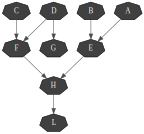

In [9]:
gnb.showCN(cn,"2")

In [10]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertEvidenceFile(os.path.join("res","cn/L2U.evi"))

In [11]:
ie.setRepetitiveInd(False)
ie.setMaxTime(1)
ie.setMaxIter(1000)

ie.makeInference()

In [12]:
gnb.sideBySide(cn,gnb.getInference(cn,targets={"A","H","L","D"},engine=ie,evs={"L":[0,1],"G":[1,0]}))

# Comparing inference in credal networks

In [13]:
import pyAgrum as gum

def showDiffInference(model,mc,lbp):
    for i in model.current_bn().nodes():
        a,b=mc.marginalMin(i)[:]
        c,d=mc.marginalMax(i)[:]
        
        e,f=lbp.marginalMin(i)[:]
        g,h=lbp.marginalMax(i)[:]
        
        plt.scatter([a,b,c,d],[e,f,g,h])
        

cn=gum.CredalNet("res/cn/2Umin.bif","res/cn/2Umax.bif")
cn.intervalToCredal()

#### The two inference give quite the same result

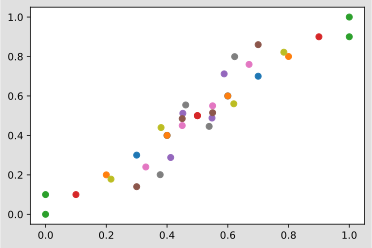

In [14]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.makeInference()

cn.computeBinaryCPTMinMax()
ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)

#### but not when evidence are inserted

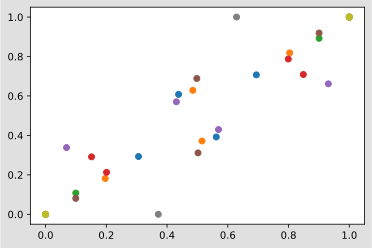

In [15]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.insertEvidenceFile("res/cn/L2U.evi")
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.insertEvidenceFile("res/cn/L2U.evi")
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)


## Dynamical Credal Net

In [16]:
cn=gum.CredalNet(os.path.join("res","cn/bn_c_8.bif"),os.path.join("res","cn/den_c_8.bif"))
cn.bnToCredal(0.8,False)

In [17]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(True)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()

In [18]:
print(ie.dynamicExpMax("temp"))

(13.796595325898947, 11.391276171798012, 11.975872407675427, 11.896583956121429, 11.878306821734771, 11.893801234291967, 11.888524791710616, 11.889469448341735, 11.889530396098476)


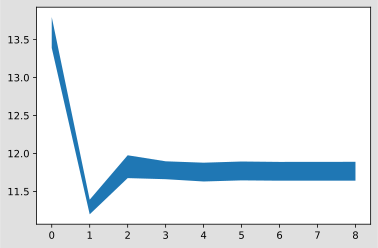

In [19]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

In [20]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()


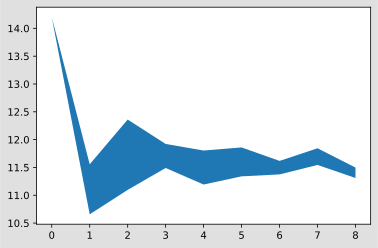

In [21]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

stopped with epsilon=0


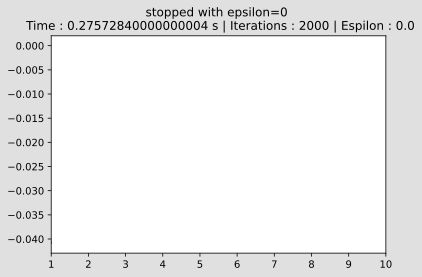

In [22]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(5000)

gnb.animApproximationScheme(ie)
ie.makeInference()
print(ie.messageApproximationScheme())

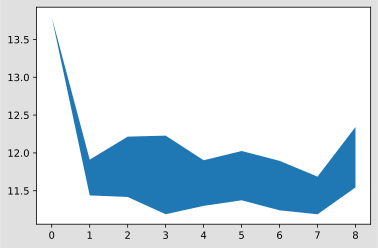

In [23]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"));